In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [2]:
amps = True
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpLMAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpLM
    import cklemap.ckli.mapest_old as mapest

In [3]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [4]:
# Parameters
res_fac = 1
resolution = '1x'
resolution_iYobs = '16x'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 0
lsq_method = 'trf'
run_PICKLE = True
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF1/conduct_log_RF1_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = "Yref=orig"

In [5]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('conduct_log')[:].ravel() - Yfac

In [6]:
prob = DarcyExp(TPFA(geom, bc), None)
uref = prob.randomize_bc('N', Neumann_sd).solve(Yref)

In [7]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [8]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

In [9]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [10]:
if os.path.exists(yobs_filename):
    print(f"iYobs read from file {yobs_filename}")
    iYobs_fine = np.load(yobs_filename)
    print(iYobs_fine.shape)
    geom_fine = GeomMRST(geom_fine_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs read from file ../data/yobs/yobs_25_16x.npy
(10, 25)
iYobs.shape=(1, 25)
[[  27   97  203  410  534  626  626  654  685  830  850  860  873  907
   942  960  972  973 1021 1149 1200 1296 1327 1418 1459]]


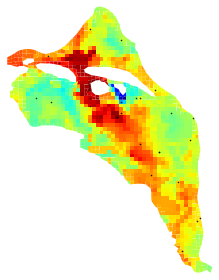

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yref', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_NY={NYobs}_1x_from_4x.pdf', dpi=300)

In [12]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{Nuxi=}_{NYxi=}_beta={beta_ckli}_gamma={ugamma_ckli}_{Neumann_sd=}_{lsq_method=}_h1reg_{ref}'
print(exp)

timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

uxi = np.zeros((num_trials, Nuxi))
Yxi = np.zeros((num_trials, NYxi))
uest = np.zeros((num_trials, Nc))
Yest = np.zeros((num_trials, Nc))
Yest_MAPH1 = np.zeros((num_trials, Nc))
if Neumann_sd != 0:
    Nq = np.count_nonzero(bc.kind == 'N')
    q_MAPH1 = np.zeros((num_trials, Nq))

NY=25_Nu=323_NYlearn=25_Nuxi=1000_NYxi=1000_beta=10.0_gamma=0.0001_Neumann_sd=0_lsq_method='trf'_h1reg_Yref=orig


In [13]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f'{klearn.lengthscale.values[0]}')

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   2.070918e+02   2.681430e+05 
    00s01  0004   5.574250e+01   2.910726e+02 
    00s02  0006   4.551667e+01   2.258707e+01 
    00s03  0011   4.135385e+01   6.619892e-01 
    00s06  0020   4.116347e+01   2.996674e-03 
    00s09  0029   4.122891e+01   5.141146e-01 
    00s10  0031   4.116126e+01   3.138040e-07 
Runtime:     00s10
Optimization status: Converged

0.040670603721217946
GPR: [0.35338496] s


In [14]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, copy.deepcopy(prob), rs, randomize_bc=True, randomize_scale=Neumann_sd)
        upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
        timings[t, 1] = perf_counter() - ts

    print(f"Monte Carlo: {timings[:, 1]} s")

Monte Carlo: [22.20863648] s


In [15]:
if run_PICKLE:
    Ym = Ypred
    CYm = CYpred
    um = umean #or change to upred
    Cum = Cu #or change to Cupred

    rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
    abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

    print(f"GPR\tRelative error: {rel_errors[:, 0]}")
    print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.723198]
GPR	Infinity error: [4.40831609]


In [16]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
        Psiu[t], Lambdau[t] = ckliest.KL_via_eigh(Cum[t], Nuxi)
        timings[t, 2] = perf_counter() - ts

    print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [3.34825373] s


In [17]:
# PICKLE estimate
ssv = None if Neumann_sd == 0 else np.delete(np.arange(Nc), np.unique(geom.cells.to_hf[2*geom.faces.num_interior:][bc.kind == 'N']))
Lreg = mapest.compute_Lreg(geom)

if run_PICKLE:
    for t in range(num_trials):
        res = ckliest.LeastSqRes(NYxi, Ym[t], PsiY[t], Nuxi, um[t], Psiu[t], prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs[t], Yobs[t], beta_ckli, ssv=ssv)

        ts = perf_counter()
        sol = spo.least_squares(res.val, np.zeros(Nuxi + NYxi), jac=res.jac, method=lsq_method, verbose=2)
        ckli_status = sol.status
        timings[t, 3] = perf_counter() - ts
        nfevs[t, 0] = sol.nfev
        print(f'CKLI optimality: {sol.optimality : g}')

        uxi[t] = sol.x[:Nuxi]
        Yxi[t] = sol.x[Nuxi:]
        uest[t] = um[t] + Psiu[t] @ uxi[t]
        Yest[t] = Ym[t] + PsiY[t] @ Yxi[t]

    rel_errors[:, 1] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
    abs_errors[:, 1] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

    print(f"PICKLE: {timings[:, 3]} s")
    print(f"PICKLE\trelative L2 error: {rel_errors[:, 1]}")
    print(f"PICKLE\tabsolute infinity error: {abs_errors[:, 1]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.4825e+03                                    7.85e+03    
       1              2         1.0604e+03      6.42e+03       1.00e+00       1.72e+03    
       2              3         1.3231e+02      9.28e+02       2.00e+00       3.32e+01    
       3             18         1.3231e+02      0.00e+00       0.00e+00       3.32e+01    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 7.4825e+03, final cost 1.3231e+02, first-order optimality 3.32e+01.
CKLI optimality:  33.2462
PICKLE: [11.96342425] s
PICKLE	relative L2 error: [0.73924426]
PICKLE	absolute infinity error: [4.44736561]


In [18]:
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    # MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpLMAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    else:
        dasa = DASAExpLM(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest_MAPH1[t] = sol.x
    
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'MAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref) for t in range(num_trials)])

print(f"MAP: {timings[:, 4]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.4313e+02                                    5.84e+01    
       1              2         5.3419e+02      1.09e+02       1.00e+00       4.92e+01    
       2              3         3.5653e+02      1.78e+02       2.00e+00       2.87e+01    
       3              4         1.6602e+02      1.91e+02       4.00e+00       6.10e+00    
       4              5         6.0042e+01      1.06e+02       8.00e+00       2.06e+00    
       5              6         1.3075e+01      4.70e+01       1.60e+01       4.63e+00    
       6              7         3.0620e+00      1.00e+01       3.20e+01       3.22e+00    
       7              9         7.8364e-02      2.98e+00       8.14e+00       2.19e-01    
       8             11         1.2432e-02      6.59e-02       4.07e+00       5.34e-02    
       9             12         1.2233e-02      1.98e-04       8.14e+00       9.66e-02    

In [20]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YPICKLE/YPICKLE_{exp}.txt', Yest)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest_MAPH1)

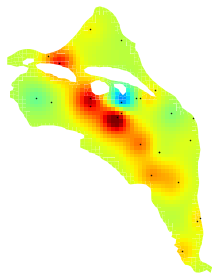

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, Yest[0, :] + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yest (PICKLE)', 0, 12)

fig.tight_layout()
fig.savefig(figures_path + f'YPICKLE/YPICKLE_{exp}.pdf', dpi=300)

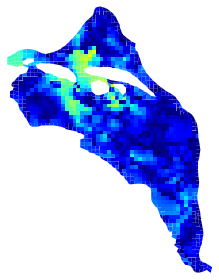

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, np.abs(Yest[0, :] - Yref), fig, ax, geom.cells.centroids[:, iYobs], 'Ydiff (PICKLE)', 0, 7)

fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_PICKLE/Ydiff_PICKLE_{exp}.pdf', dpi=300)

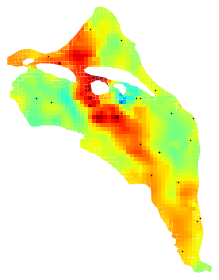

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, Yest_MAPH1[0, :] + Yfac, fig, ax, geom.cells.centroids[:, iYobs], 'Yest (MAP)', 0, 12)

fig.tight_layout()
fig.savefig(figures_path + f'YMAP/YMAP_{exp}.pdf', dpi=300)

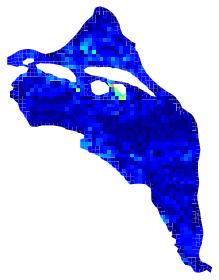

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, np.abs(Yest_MAPH1[0, :] - Yref), fig, ax, geom.cells.centroids[:, iYobs], 'Ydiff (MAP)', 0, 7)

fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_MAP/Ydiff_MAP_{exp}.pdf', dpi=300)